### Aditya Jhaveri : N13689134
#### Lab - 2

# Lab:  Model Order Selection for Neural Data

Machine learning is a key tool for neuroscientists to understand how sensory and motor signals are encoded in the brain.  In addition to improving our scientific understanding of neural phenomena, understanding neural encoding is critical for brain machine interfaces (see. e.g. https://www.youtube.com/watch?v=QRt8QCx3BCo).  In this lab, you will use model selection for performing some simple analysis on real neural signals.  

Before doing this lab, you should review the ideas in the polynomial model selection demo.  In addition to the concepts in that demo, you will learn to:
* Represent neural time-series data in arrays
* Load data from a pickle file
* Describe and fit memoryless linear models
* Describe and fit linear time-series models with delays
* Fit linear models with multiple target outputs
* Select the optimal delay via cross-validation

## Loading the data

The data in this lab comes from neural recordings described in:

<a href="https://pubmed.ncbi.nlm.nih.gov/21613593/">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a>

Neurons are the basic information processing units in the brain.  Neurons communicate with one another via *spikes* or *action potentials* which are brief events where voltage in the neuron rapidly rises then falls.  These spikes trigger the electro-chemical signals between one neuron and another.  In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain.  During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.  

The goal of the experiment is to try to *read the monkey's brain*:  That is, predict the hand motion from the neural signals from the motor cortex. Being able to make such predictions is the precursor to [technologies like Braingate and Neuralink](https://www.youtube.com/watch?v=QRt8QCx3BCo) that use electrode implants to read neural activity that then controls a cursor or robotic arm.

We first load the key packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

The full data is available on the CRCNS website  http://crcns.org/data-sets/movements/dream.  This website has a large number of datasets and can be used for projects as well.  However, the raw data files can be quite large.  To make the lab easier, the [Kording lab](http://kordinglab.com/) at UPenn has put together an excellent [repository](https://github.com/KordingLab/Neural_Decoding) where they have created simple pre-processed versions of the data.  You can download the file `example_data_s1.pickle` from [this link](https://github.com/cpmusco/machinelearning2022/blob/master/data/example_data_s1.pickle?raw=true).  Alternatively, you can directly run the following code.

In [2]:
fn_src = 'https://github.com/cpmusco/machinelearning2022/blob/master/data/example_data_s1.pickle?raw=true'
fn_dst = 'example_data_s1.pickle'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:
    urllib.request.urlretrieve(fn_src, fn_dst)

File example_data_s1.pickle is already downloaded


The file is a *pickle* data structure, which is a package to serialize python objects into data files.  Once you have downloaded the file, you can run the following command to retrieve the data from the pickle file.

In [3]:
with open('example_data_s1.pickle', 'rb') as fp:
    X,y = pickle.load(fp)

The matrix `X` is matrix of spike counts where `X[i,j]` is the number of spikes from neuron `j` in time bin `i`.
The matrix `y` has two columns:
* `y[i,0] = ` velocity of the monkey's hand in the x-direction
* `y[i,1] = ` velocity of the monkey's hand in the y-direction

Our goal will be to predict **only** `y[i,0]` from `X`. We could just as easily predict movement in both directions, but this simplifies the lab.  So we reassign:

In [4]:
y = y[:,0]

Each time bin represent `tsamp=0.05` seconds of time.  Using `X.shape` and `y.shape` compute and print:
* `nt = ` the total number of time bins
* `nneuron = ` the total number of neurons
* `ttotal = ` total time of the experiment is seconds.

In [5]:
tsamp = 0.05  # sampling time in seconds

nt, nneurons = X.shape
print(f"Total number of time bins: {nt}")
print(f"Total number of neurons: {nneurons}")
ttotal = nt*tsamp
print(f"Total time of the experiment: {ttotal} seconds")

Total number of time bins: 61339
Total number of neurons: 52
Total time of the experiment: 3066.9500000000003 seconds


## Fitting a Memoryless Linear Model

Let's first try a simple linear regression model to fit the data.

Before doing so, we want to split the data into a training and test set. We will use a 2/3 - 1/3 split, so 1/3 of the data should be used for testing.

Let `Xtr,ytr` be the training data set and `Xts,yts` be the test data set. Recall that `ytr` and `yts` should be taken from the *first column of `y` only*. You can use any utility to perform the split that you want, but make sure that it is *random*. I.e. don't just take the first rows of the data to be the training data. `np.random.permutation` might come in handy.

In [6]:
def splitTrainTest(X, y, fraction):
    indices = np.random.permutation(X.shape[0])
    split_index = int(X.shape[0] * (fraction))
    train = indices[:split_index]
    test = indices[split_index:]

    Xtr = X[train]
    Xts = X[test]
    ytr = y[train]
    yts = y[test]
    return Xtr, Xts, ytr, yts

In [7]:
Xtr, Xts, ytr, yts = splitTrainTest(X, y, 0.33)
print(Xtr.shape, Xts.shape, ytr.shape, yts.shape)

(20241, 52) (41098, 52) (20241,) (41098,)


Next, write an function that, fits a linear model given a predictor matrix X and a vector of target values y. Your function should find the optimal beta to minimize the squared loss. You should do so using the matrix equations discussed in class -- do not use any built in functions from e.g. Scikit Learn.

 Your linear model should have an intercept (a column of all oness). Hint: You might want to use numpy's concatenate function and the ones function.

In [8]:
def fit_mult_linear(X,y):
    """
    Given matrix of predictors X and target vector y fit for a multiple linear regression model under the squared loss.
    """
    ones_column = np.ones((X.shape[0], 1))
    X_cept = np.concatenate((ones_column, X), axis=1)
    beta = np.linalg.inv(np.transpose(X_cept) @ X_cept) @ (np.transpose(X_cept)) @ y
    return beta

Now, use your function to fit a multiple linear regression model under squared loss using `Xtr,ytr`.
Make predictions  `yhat` using `Xts`.

In [9]:
beta = fit_mult_linear(Xtr, ytr)

ones_test_column = np.ones((Xts.shape[0], 1))
Xts_cept = np.concatenate((ones_test_column, Xts), axis=1)


yhat = Xts_cept @ beta

Compare `yhat` to `yts` to measure the **averaged squared loss** (empirical risk) on the test set. Print the output. You should obtain an average loss of around 32 or 33 if you are normalizing by 1/(test set size).

In [10]:
mean_loss = np.mean((yhat - yts)**2)
print(f"Average Squared loss (Empirical Risk): {mean_loss}")

Average Squared loss (Empirical Risk): 32.12518350903315


It is useful to plot the predicted vs. true values. Plot `yhat` vs. `yts` with a scatter plot and label the axes. If the predicted values exactly matched the targets, we would expect to see a line with slope 1.

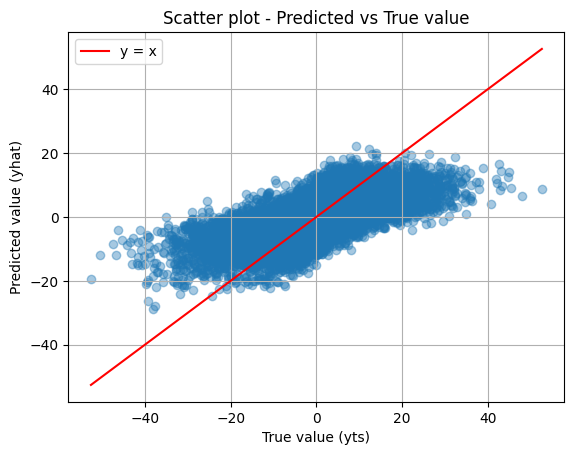

In [11]:
plt.scatter(yts, yhat, alpha=0.4)

plt.plot([min(yts), max(yts)], [min(yts), max(yts)], 'r-', label = 'y = x')

plt.xlabel('True value (yts)')
plt.ylabel('Predicted value (yhat)')

plt.title('Scatter plot - Predicted vs True value')
plt.grid(True)
plt.legend()

plt.show()

## Fitting Models with Delay

One way we can improve the model accuracy is to used delayed version of the features.  Specifically, the model we used above mapped the features

$$
\hat{y}_i = \sum_{j=1}^{p} X_{i,j}*\beta_j + \beta_0
$$
where $p$ is the number of features and $\beta$ is our vector of coefficients.  In this model,  $\hat{y}_i$ at time $i$ was only dependent on the inputs  $X_{i,1,\ldots,p}$ at time $i$.  In signal processing, this is called a *memoryless* model.  However, in many physical systems, such as those that arise in neuroscience, there is a delay between the inputs $X_{i,1,\ldots,p}$ and the outputs $y_i$.  For such cases, we can use a model of the form,

$$
\hat{y}_{i+d} = \sum_{m=0}^d \sum_{j=1}^{p} X_{i+m,j}*\beta_{j,m} + \beta_{0,m}
$$
    
where $\beta$ is now a 2-dim array of coefficients where $\beta_{j,m}$ is the influence of the input $X_{i+m,j}$ onto output $y_{i+d}$


In signal processing, this model is called an *FIR* filter.  The point is that the output at time `i+d` depends on the inputs at times `i,i+1,...,i+d`.  Hence, it depends on the last `d+1` time steps, not just the most recent time.

To translate this into a linear regression problem, complete the following function that creates a new feature and target matrix where:

    Xdly[i,:] is the concatenation of the vectors X[i,:], X[i+1,:], ..., X[i+d,:]
    ydly[i,:] = y[i+d,:]
    
Note that if `X` is `n x p` then `Xdly` will be `n-d x (d+1)*p`.  


In [12]:
def create_dly_data(X,y,d):
    """
    Create delayed data
    """
    n, p = X.shape
    Xdly = np.zeros((n - d, (d+1)*p))

    for i in range(n - d):
        Xdly[i, :] = X[i:i + d + 1, :].flatten()

    ydly = y[d:]

    return Xdly, ydly


Now fit an linear delayed model with `d=6` additional delay lags.  That is,
* Create delayed data `Xdly,ydly=create_dly_data(X,y,6)`
* Split the data into training and test as before
* Fit the model on the training data
* Measure the average squared loss (risk) on the test data

You should see a significant improvement from the memoryless model.

In [13]:
Xdly, ydly = create_dly_data(X, y, 6)
print(X.shape, y.shape)
print(Xdly.shape, ydly.shape)

(61339, 52) (61339,)
(61333, 364) (61333,)


In [14]:
# Splitting the data

Xtr2, Xts2, ytr2, yts2 = splitTrainTest(Xdly, ydly, 0.67)
print(Xtr2.shape, Xts2.shape, ytr2.shape, yts2.shape)

(41093, 364) (20240, 364) (41093,) (20240,)


In [15]:
# Fitting the model

beta_dly = fit_mult_linear(Xtr2, ytr2)
ones_test_column = np.ones((Xts2.shape[0], 1))
Xts2_cept = np.concatenate((ones_test_column, Xts2), axis=1)
yhat_dly = Xts2_cept @ beta_dly

avg_loss_dly_6 = np.mean((yhat_dly - yts2)**2)

print(f"The Average Squared Loss for d=6 is {avg_loss_dly_6}")

The Average Squared Loss for d=6 is 17.9431968937425


Plot the predicted vs. true values as before. You should visually see the improvement too.

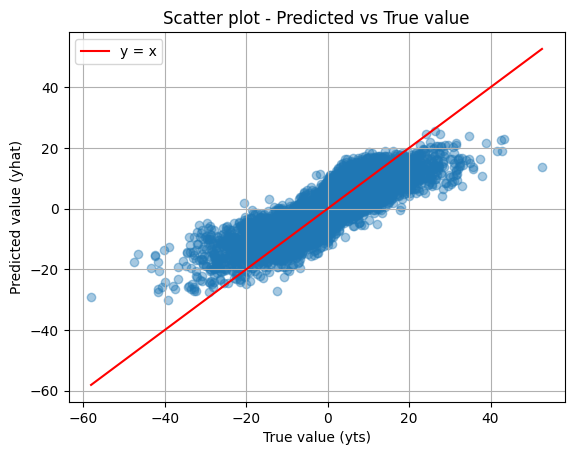

In [16]:
plt.scatter(yts2, yhat_dly, alpha=0.4)

plt.plot([min(yts2), max(yts2)], [min(yts2), max(yts2)], 'r-', label = 'y = x')

plt.xlabel('True value (yts)')
plt.ylabel('Predicted value (yhat)')

plt.title('Scatter plot - Predicted vs True value')
plt.grid(True)
plt.legend()

plt.show()

## Selecting the Optimal Delay via Model Order Selection

In the previous example, we fixed `d=6`.  We can now select the optimal delay using model order selection.  Since we have a large number of data samples, it turns out that the optimal model order uses a very high delay.  
So to save on computation time, we will just do a simple train-test split. We won't do any k-fold cross-validation.

We will look at model orders up to `dmax=30`.  Create a delayed dataset, `Xdly,ydly` using `create_dly_data` with `dly=dmax`. Split this data into training and test data as before, with a 2/3 -1/3 split.

In [32]:
dmax = 60

# For Approach 1

doptimum = None
losses = []
min_avg_err = float('inf')

# For Approach 2

losses_subset = []
doptimum_subset = None
min_avg_err_2 = float('inf')

Implement a loop to test different amounts of delay from 0 to `dmax`. For each delay, you should train on the train set and compute the average squared loss on the test set. Store these losses in an array `losses`.

In [33]:
doptimum = None
losses = []
min_avg_err = float('inf')
for d in range(0, dmax + 1):
    Xdly, ydly = create_dly_data(X, y, d)

    Xtr_dly, Xts_dly, ytr_dly, yts_dly = splitTrainTest(Xdly, ydly, 0.67)
    beta_dly = fit_mult_linear(Xtr_dly, ytr_dly)

    ones_test_column = np.ones((Xts_dly.shape[0], 1))
    Xts_dly_cept = np.concatenate((ones_test_column, Xts_dly), axis=1)
    yhat_dly = Xts_dly_cept @ beta_dly

    avg_loss_dly = np.mean((yhat_dly - yts_dly)**2)

    print(avg_loss_dly)

    if avg_loss_dly < min_avg_err:
        min_avg_err = avg_loss_dly
        doptimum = d
    losses.append(avg_loss_dly)

print(f"The optimal value of d for dmax={dmax} with lowest average sqared loss is: {doptimum}")
print(f"The minimum average squared loss for dmax={dmax} is: {min_avg_err}")

32.17862677193679
25.061073083122725
22.244837821649554
20.2293750582328
19.053214565674367
17.864472139249767
17.69998974167573
17.040905118292088
16.66288063275589
16.620937637854635
16.553621420756006
16.286559383658044
16.20511459705935
16.3350664144316
15.985374420958347
16.256424004432795
16.608499843981484
15.945033022074561
16.035860755019183
16.54441018185007
16.396564621335397
16.2684625465547
16.336183074022756
16.366685704859048
16.27071930602667
16.27137964715411
16.129640315390372
16.40554406931238
16.565911872286605
16.3538137982539
16.14488703899754
16.023928318518614
16.50146635719051
16.81966925721837
16.123982713387896
16.880986217351822
16.87588206181601
16.158632061314442
16.73539118757149
16.560611174583904
16.91796240434091
16.33303214159441
16.78707524013266
16.81320070430454
16.803170684960197
16.826203748648087
16.87777351370762
16.468738404610665
16.85128270840954
16.99480590786869
16.83703257220354
16.85200723439765
16.82033743313336
17.053445852226908
17.16

Which amount of delay lead to the best model fit? Plot losses as a function of `range(0,dmax)` to visualize how generalization of your model changes with increasing complexity

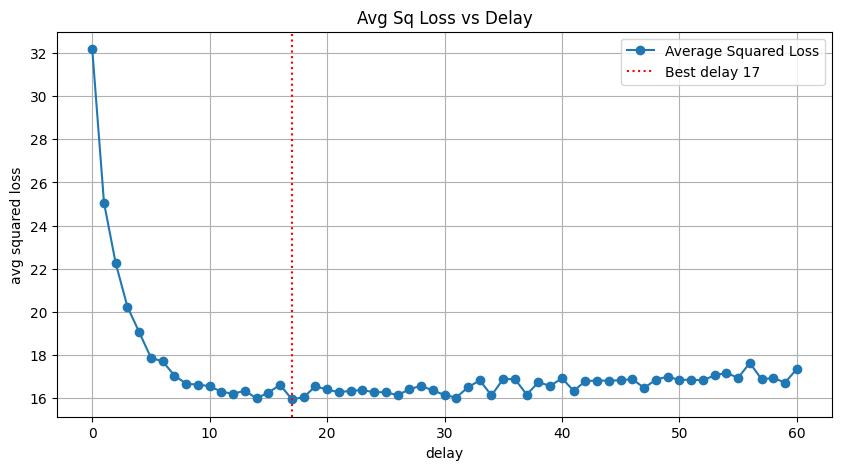

In [34]:
# TODO
# best_delay=

plt.figure(figsize=(10, 5))
plt.plot(range(0, dmax + 1), losses, marker='o')
plt.title("Avg Sq Loss vs Delay")
plt.xlabel("delay")
plt.ylabel("avg squared loss")
plt.axvline(x = doptimum, linestyle=':', color='red')
plt.legend(['Average Squared Loss', f'Best delay {doptimum}'])
plt.grid()
plt.show()

**Important Note**: for different delay values you should be using a different **subset of columns** from the `Xdly` matrix you just created. To save time, you don't want to be re-creating a new test set for each model order you experiment with.

Your code could take a long time (several minutes) to run! This is a large data set and we are using many features in our multivariate regression. You might want to test/debug your code with a signficantly small value of `dmax` before doing a final run.

In [35]:
def create_dly_subset(X, y, dmax):
    n, p = X.shape
    Xdly_s = np.zeros((n - dmax, (dmax+1)*p))
    for i in range(n - dmax):
        Xdly_s[i, :] = X[i:i+dmax+1, :].flatten()
    # X_dly = np.hstack([np.roll(X, shift=i, axis=0) for i in range(0, dmax+1)])
    print(X.shape, Xdly_s.shape)
    for d in range(1, dmax + 1):
        x = Xdly_s[X.shape[0] - dmax - 1, :p*(dmax-d+1)]
        t = np.empty(Xdly_s.shape[1])
        t[:Xdly_s.shape[1] - d*p] = x
        Xdly_s = np.vstack([Xdly_s, t])

    return Xdly_s, y

In [36]:
Xdly_max, ydly_max = create_dly_subset(X, y, dmax)
print(Xdly_max.shape, ydly_max.shape)

(61339, 52) (61279, 3172)
(61339, 3172) (61339,)


In [37]:
# Approach 2

losses_subset = []
doptimum_subset = None
min_avg_err_2 = float('inf')

for d in range(0, dmax+1):
    Xdly_d, ydly_d = Xdly_max[:Xdly_max.shape[0] - d, :X.shape[1]*(d+1)], y[d:]
    print(Xdly_d.shape, ydly_d.shape)
    Xtr_dly_d, Xts_dly_d, ytr_dly_d, yts_dly_d = splitTrainTest(Xdly_d, ydly_d, 0.67)

    beta_dly_d = fit_mult_linear(Xtr_dly_d, ytr_dly_d)
    ones_test_column = np.ones((Xts_dly_d.shape[0], 1))
    Xts_d_cept = np.concatenate((ones_test_column, Xts_dly_d), axis=1)
    yhat_dly_d = Xts_d_cept @ beta_dly_d

    avg_loss_dly = np.mean((yhat_dly_d - yts_dly_d)**2)

    print(avg_loss_dly)
    if avg_loss_dly < min_avg_err_2:
        min_avg_err_2 = avg_loss_dly
        doptimum_subset = d
    losses_subset.append(avg_loss_dly)

print(f"The optimal value of d for dmax={dmax} with lowest average sqared loss is: {doptimum_subset}")
print(f"The minimum average squared loss for dmax={dmax} is: {min_avg_err_2}")

(61339, 52) (61339,)
31.391472771981103
(61338, 104) (61338,)
24.978867567648976
(61337, 156) (61337,)
21.997684907540368
(61336, 208) (61336,)
20.569544054039532
(61335, 260) (61335,)
19.048789270019828
(61334, 312) (61334,)
18.557851495489466
(61333, 364) (61333,)
17.535179493683952
(61332, 416) (61332,)
17.07973620226046
(61331, 468) (61331,)
16.980912302135778
(61330, 520) (61330,)
16.766432896725576
(61329, 572) (61329,)
16.4569279906424
(61328, 624) (61328,)
16.43451265703541
(61327, 676) (61327,)
16.367552769326313
(61326, 728) (61326,)
16.31191455304435
(61325, 780) (61325,)
16.523608475997218
(61324, 832) (61324,)
16.292984669447033
(61323, 884) (61323,)
16.088609305608053
(61322, 936) (61322,)
16.30615949646319
(61321, 988) (61321,)
16.465006593563132
(61320, 1040) (61320,)
15.483447393263697
(61319, 1092) (61319,)
16.33346416281499
(61318, 1144) (61318,)
16.286264231432344
(61317, 1196) (61317,)
15.935764320228426
(61316, 1248) (61316,)
16.215293076891708
(61315, 1300) (6131

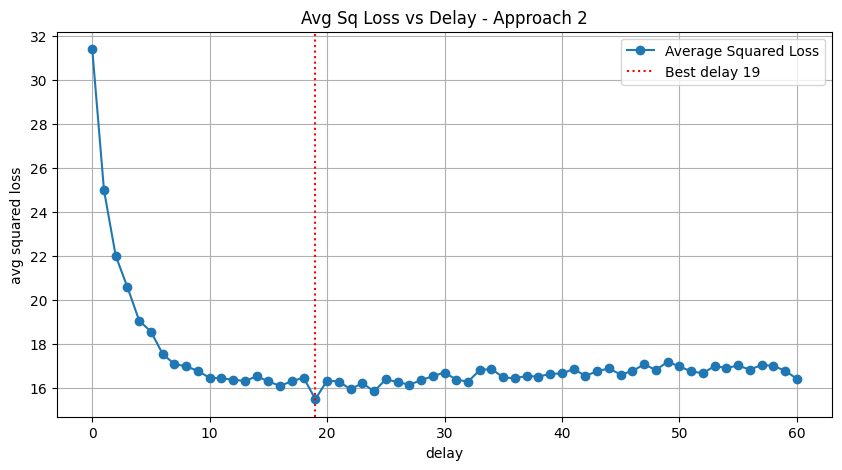

In [38]:
# Plot the graph

plt.figure(figsize=(10, 5))
plt.plot(range(0, dmax + 1), losses_subset, marker='o')
plt.title("Avg Sq Loss vs Delay - Approach 2")
plt.xlabel("delay")
plt.ylabel("avg squared loss")
plt.axvline(x = doptimum_subset, linestyle=':', color='red')
plt.legend(['Average Squared Loss', f'Best delay {doptimum_subset}'])
plt.grid()
plt.show()

### Conclusion

- When dmax=30, both the approaches only had like 1-2 seconds difference of execution time
- When dmax=60, we can see Approach 1, where Xdly and ydly are generated everytime, it takes 1 min 46 seconds while in Approach 2, where Xdly and ydly for dmax is generated and subsets are taken for the rest of the delay values, in fact its execution time turns out to be 1 min 38 seconds, 8 seconds difference
- As dmax increases, Approach 2 would turn out to be more beneficial in terms of time and space both

~ Aditya Jhaveri : N13689134